In [ ]:
pip install numpy pyserial bitstring xmltodict requests scipy mne keyboard

In [ ]:
import numpy


In [ ]:
from bluepy import btle


In [ ]:
from pyOpenBCI.cyton import OpenBCICyton


In [ ]:
board.ser.close()

Serial established
Démarrage de la collecte...
Connexion à OpenBCI...
Skipped 2 bytes before start found
ID:<118> <Unexpected END_BYTE found <0> instead of <192>
Skipped 5 bytes before start found
ID:<134> <Unexpected END_BYTE found <0> instead of <192>
Skipped 8 bytes before start found


/tmp/ipykernel_13773/2247573781.py:152: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_band = np.trapz(y_interp_abs, x_interp)


Ratio combiné : 2.63 -> Bien activo
Ratio combiné : 2.64 -> Bien activo
Ratio combiné : 2.65 -> Bien activo
Ratio combiné : 2.65 -> Bien activo
Ratio combiné : 2.63 -> Bien activo
Skipped 22 bytes before start found
ID:<1> <Unexpected END_BYTE found <171> instead of <192>
Skipped 36 bytes before start found
Ratio combiné : 2.65 -> Bien activo
Ratio combiné : 2.65 -> Bien activo
Ratio combiné : 2.64 -> Bien activo
Ratio combiné : 2.65 -> Bien activo
Ratio combiné : 2.63 -> Bien activo
Arrêt manuel
Not streaming


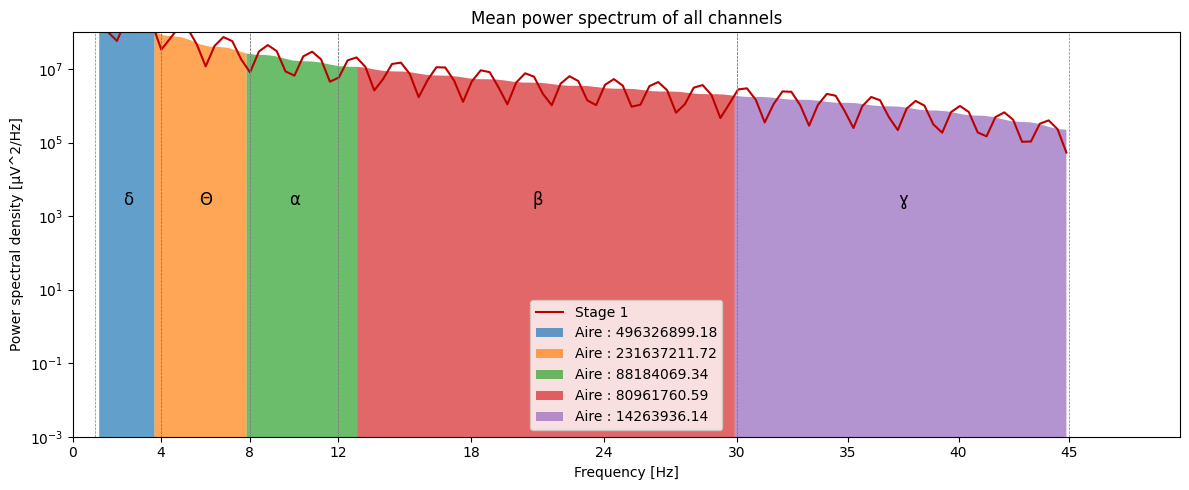

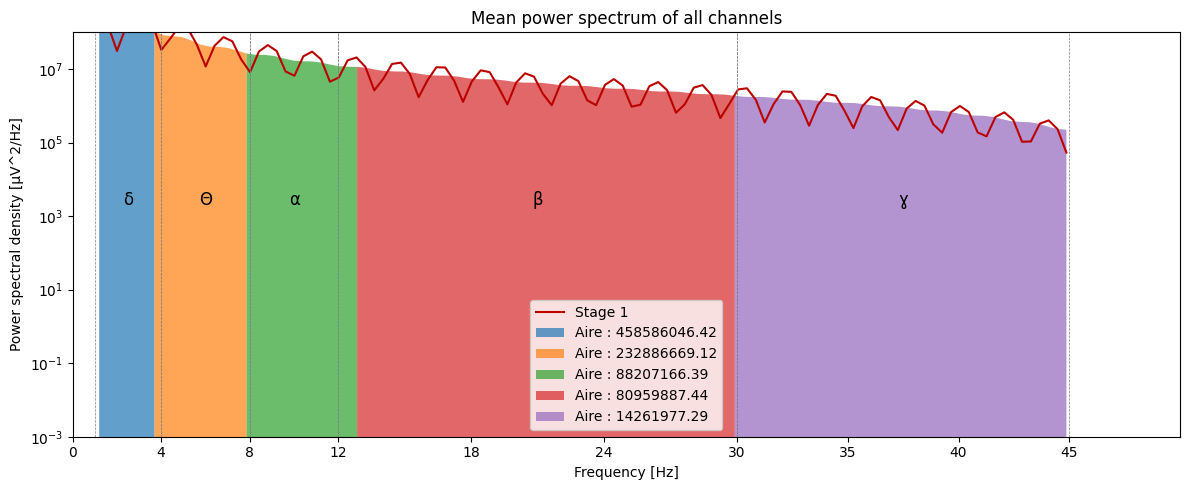

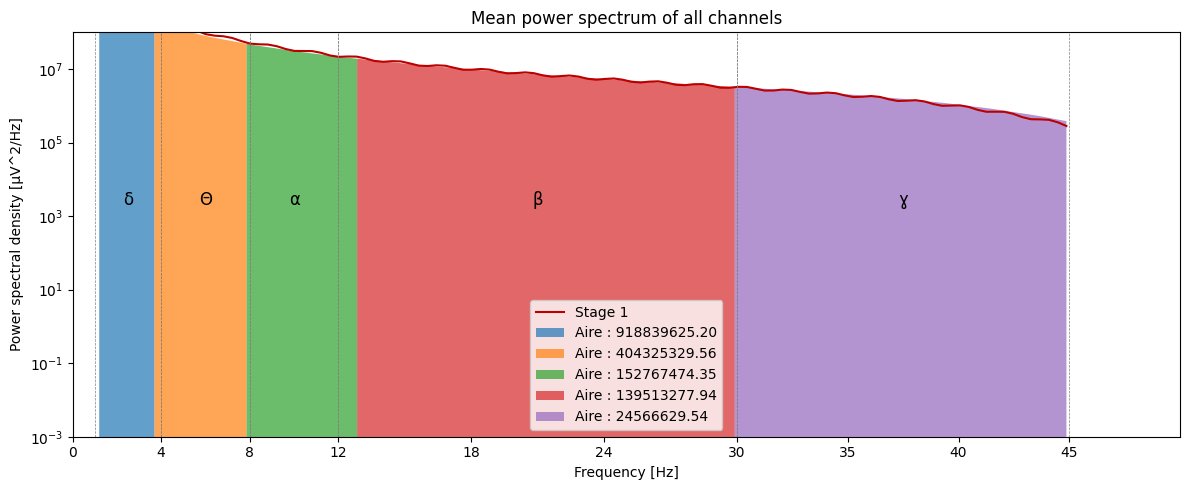

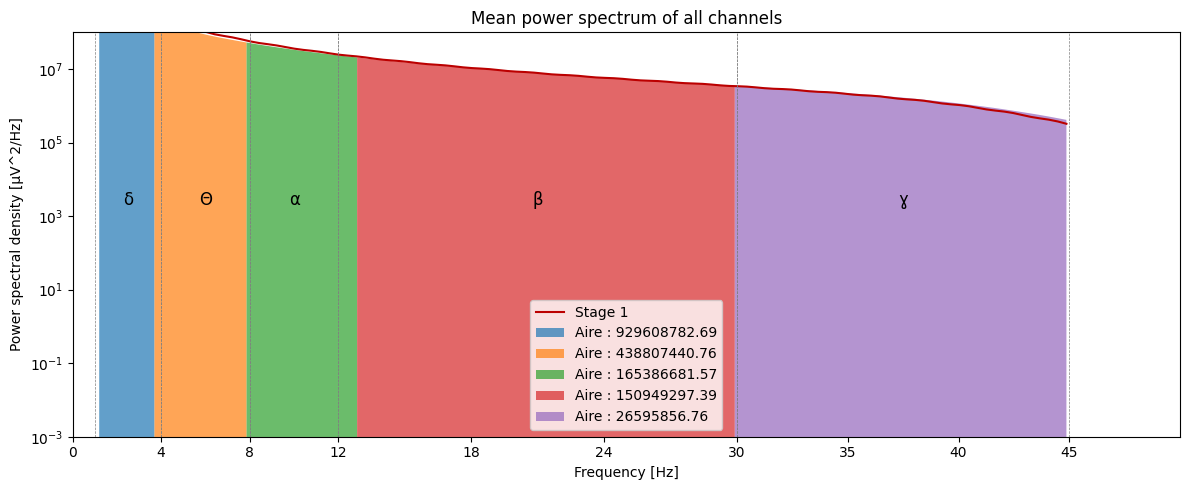

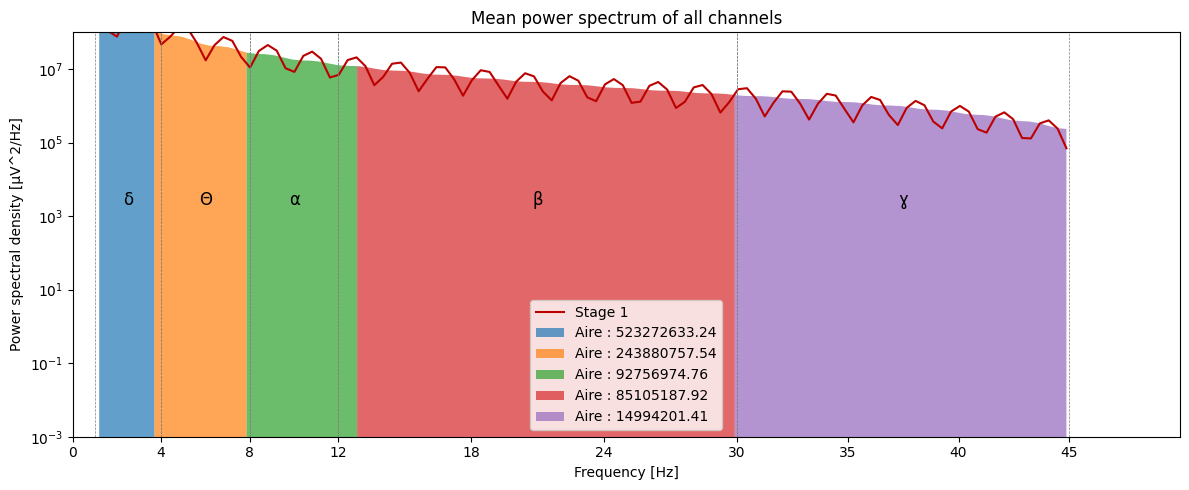

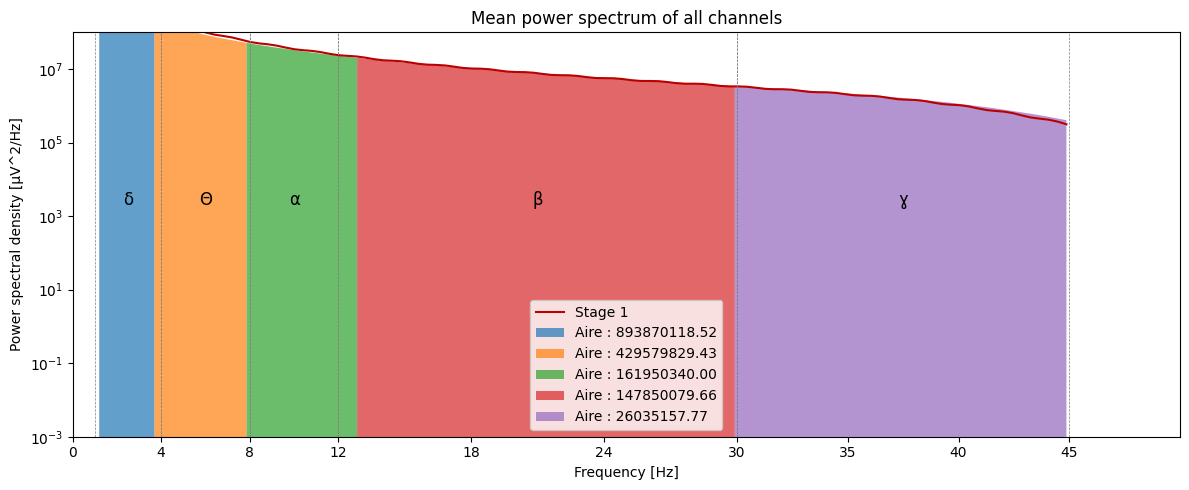

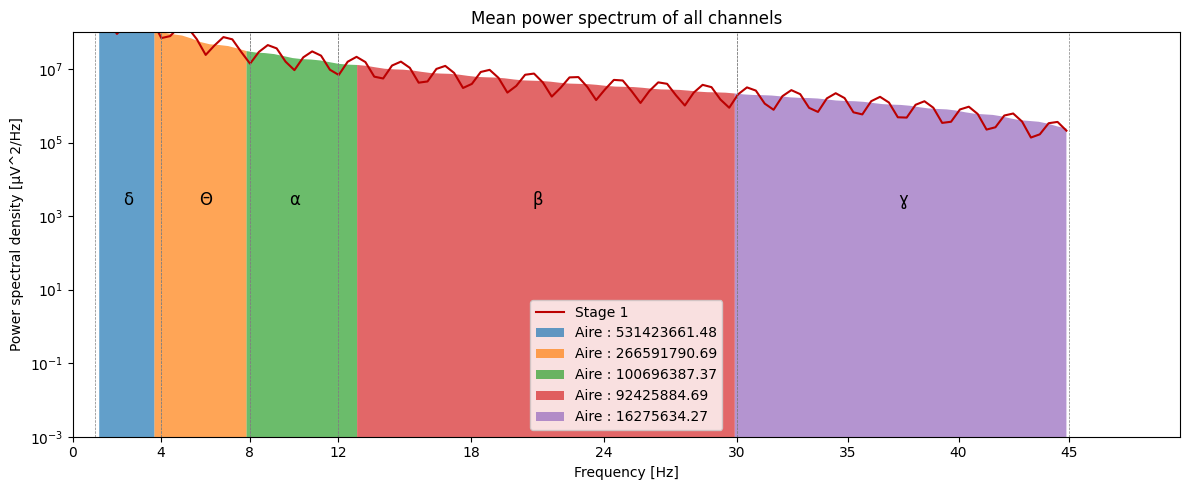

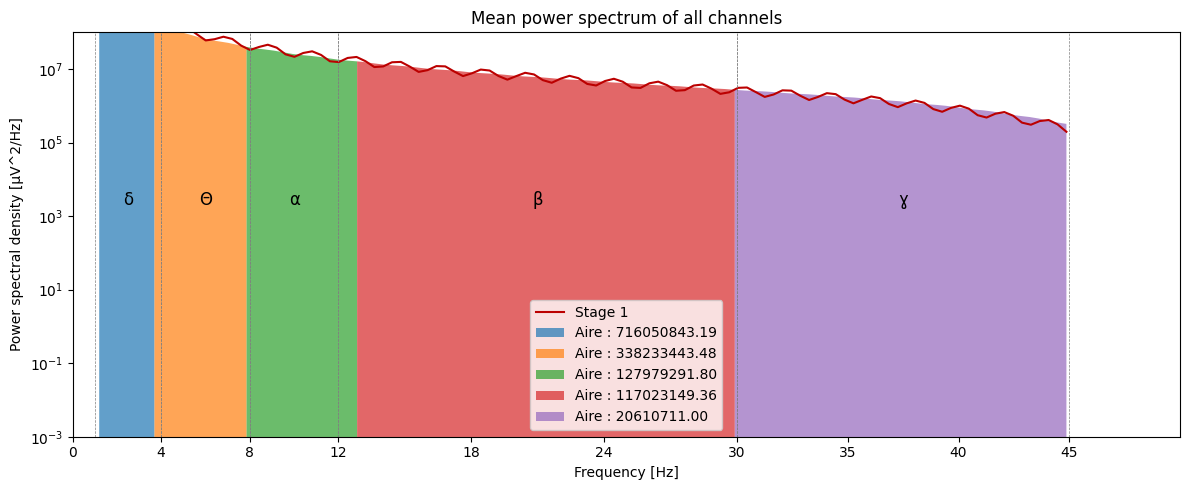

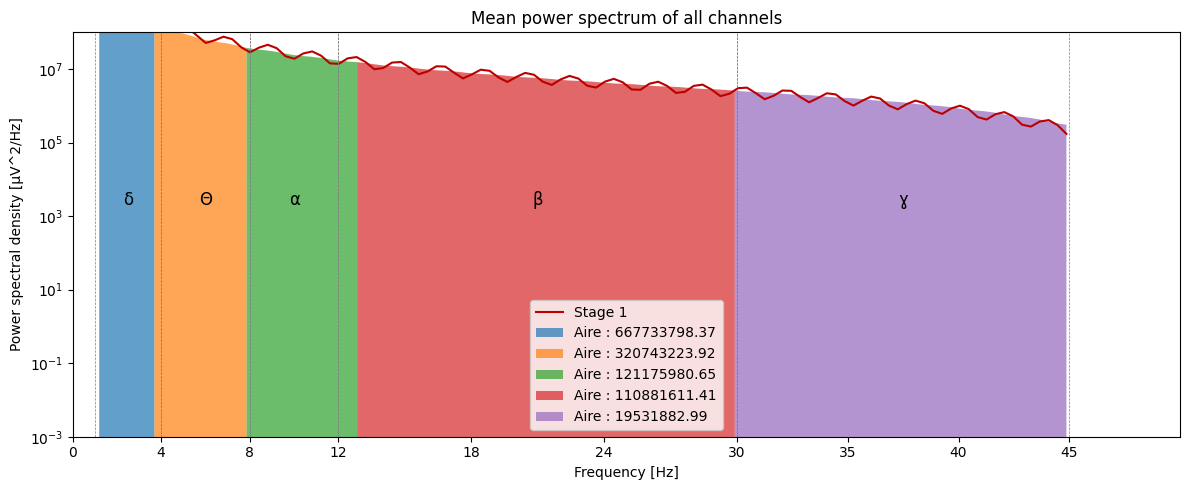

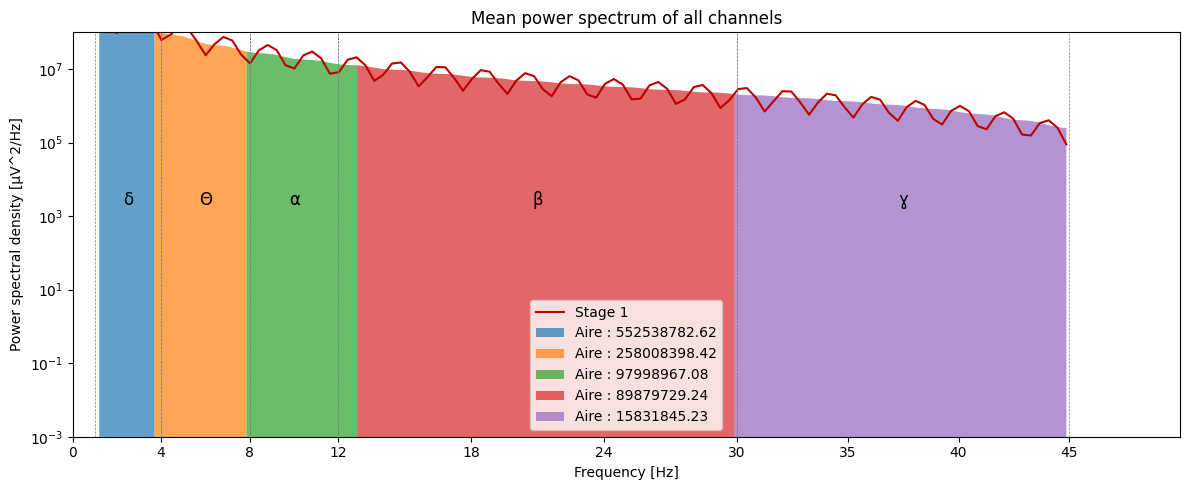

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, iirnotch
from pyOpenBCI import OpenBCICyton
import time
import threading
import mne
import keyboard
import time
import socket

UDP_IP = "192.168.0.101"  # Replace with ESP8266 IP
UDP_PORT = 4210

# === Paramètres ===
fs = 250
lowcut = 1
highcut = 45
notch_freq = 50
quality_factor = 30
BUFFER_DURATION = 2  # secondes
BUFFER_SIZE = 250 #* BUFFER_DURATION
#threshold = 4.0  # seuil empirique à ajuster

# === Filtres ===
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def bandpass_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data)

def notch_filter(data, fs, freq=50, Q=30):
    b, a = iirnotch(freq/(fs/2), Q)
    return filtfilt(b, a, data)

# === Buffers ===
buffer_ch7 = []
buffer_ch8 = []
lock = threading.Lock()

# === Collecte des données ===
def data_collector(sample):
    global buffer_ch7, buffer_ch8
    with lock:
        buffer_ch7.append(sample.channels_data[6])
        buffer_ch8.append(sample.channels_data[7])
        

# === Puissance dans une bande ===
def bandpower(f, Pxx, fmin, fmax):
    idx = np.logical_and(f >= fmin, f <= fmax)
    return np.trapz(Pxx[idx], f[idx])

ritmos = {
          'Delta' : [1,4],
          'Theta' : [4,8],
          'Alfa' : [8,13],
          'Beta' : [13,30],
          'LGamma' : [30,45]}

def graph_spectrum(freqs, ritmos, spectrum, title, condition):

    plt.figure(figsize=(12,5))
    plt.semilogy(freqs,spectrum,label='Stage 1',color='#BB0000')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.7), ncol=1) # middle = (1, 0.5) ; top = (1, 0.7)
    plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power spectral density [μV^2/Hz]')
    plt.title(title)
    plt.xlim([0,50])
    plt.xticks([0, 4, 8, 12, 18, 24, 30, 35, 40, 45])
    plt.ylim([10**-3,10**8])

    bands={ 'δ': (1, 4),
            'Θ': (4, 8),
            'α': (8, 12),
            'β': (12, 30),
            'ɣ': (30, 45)}

    for symbol, (start, end) in bands.items():
      mid = (start + end) / 2
      plt.text(mid, 10**3.2, symbol, ha='center', va='bottom', fontsize=12)
      plt.axvline(start, color='gray', linestyle='--', linewidth=0.5)
      plt.axvline(end, color='gray', linestyle='--', linewidth=0.5)


    #plt.show()

def filter_spectrum(spectrum):
    window_size = 5
    smoothed_spectrum = np.convolve(spectrum, np.ones(window_size)/window_size, mode='valid')
    #print(smoothed_spectrum)
    return smoothed_spectrum

def graph_smooth_spectrum(freqs, ritmos, spectrum, title, condition):
    smooth_spectrum_s1 = filter_spectrum(spectrum)
    smooth_freqs = np.linspace(min(freqs), max(freqs), len(smooth_spectrum_s1))
    #graph_spectrum(smooth_freqs, ritmos, smooth_spectrum_s1, title=title, condition=condition)
    return smooth_spectrum_s1

def graph_area(freqs, ritmos, spectrum, title, phase, condition):
    smooth_spectrum_s1 = filter_spectrum(spectrum)
    smooth_freqs = np.linspace(min(freqs), max(freqs), len(smooth_spectrum_s1))
    data = (smooth_freqs, smooth_spectrum_s1)

    # Initialize a dictionary to store areas under the curve per frequency band
    areas = {ritmo: 0.0 for ritmo in ritmos}

    x = data[0]
    y = data[1]

    # Track the last used frequency to ensure continuity
    last_x = None
    last_y = None

    # Calculate and display the area under the curve for each frequency band
    for ritmo, (f_min, f_max) in ritmos.items():
        # Index of points corresponding to the frequency band
        indices_band = np.where((x >= f_min) & (x <= f_max))[0]

        # If the number of points is less than 2, perform interpolation
        if len(indices_band) < 2:
            print(f"Not enough points between {f_min} Hz and {f_max} Hz, interpolating...")
            # Create a finer grid of x values between f_min and f_max
            x_interp = np.linspace(f_min, f_max, num=100)  # 100 points for finer resolution
            y_interp = np.interp(x_interp, x, y)  # Interpolate y values based on x
            
        else:
            # If enough points, use the original values
            x_band = x[indices_band]
            y_band = y[indices_band]
            x_interp = x_band
            y_interp = y_band

        # Take the absolute value of y_interp for the area under the curve
        y_interp_abs = np.abs(y_interp)

        # Ensure continuity with the previous band by adding the last point from the previous segment
        if last_x is not None and last_y is not None:
            x_interp = np.concatenate(([last_x], x_interp))
            y_interp_abs = np.concatenate(([last_y], y_interp_abs))

        # Store the last points to connect with the next band
        last_x = x_interp[-1]
        last_y = y_interp_abs[-1]

        # Calculate the area under the curve with the trapezoid method
        area_band = np.trapz(y_interp_abs, x_interp)

        # Store the area under the curve in the area dictionary
        areas[ritmo] = area_band

        # Show the area under the curve for this frequency band
        plt.fill_between(x_interp, y_interp_abs, alpha=0.7, label=f'Aire : {area_band:.2f}')

    # Show legend
    plt.legend()
    plt.xlim([0, 50])
    plt.yscale('log')
    plt.ylim([10**-3,10**8])
    plt.tight_layout()
   # plt.show()

    # Convert the areas dictionary to a NumPy array
    areas_phase = np.array(list(areas.values()))

    # Calculate relative area
    Sum = areas_phase.sum()
    area_rel = areas_phase / Sum
    #print(area_rel)

    # Return the NumPy array of areas under the curve
    return areas_phase, area_rel

# === Traitement et classification ===
def process_combined_ratios():
    global buffer_ch7, buffer_ch8
    with lock:
        if len(buffer_ch7) < BUFFER_SIZE:
            print("Pas assez de données pour calculer")
            return

        data_ch7 = np.array(buffer_ch7[-BUFFER_SIZE:])
        data_ch8 = np.array(buffer_ch8[-BUFFER_SIZE:])
    fs=250
    # Filtrage
    data_ch7 = bandpass_filter(data_ch7, lowcut, highcut, fs)
    data_ch7 = notch_filter(data_ch7, fs, notch_freq, quality_factor)

    data_ch8 = bandpass_filter(data_ch8, lowcut, highcut, fs)
    data_ch8 = notch_filter(data_ch8, fs, notch_freq, quality_factor)

    nper = 312
    fs=250
    psd = {}
    
    psd_ch7,freqs = mne.time_frequency.psd_array_welch(x = data_ch7, sfreq = 250, fmin = 1, fmax = 45, window = 'hann', n_fft = 624, n_per_seg=nper, n_overlap=int(nper/2), verbose = False)
    psd_ch8,freqs = mne.time_frequency.psd_array_welch(x = data_ch8, sfreq = 250, fmin = 1, fmax = 45, window = 'hann', n_fft = 624, n_per_seg=nper, n_overlap=int(nper/2), verbose = False)
    #print(psd_ch7)
    #print(freqs)

    PSD_Os = (psd_ch7+psd_ch8)/2
    #print(PSD_Os)


    graph_spectrum(freqs, ritmos, PSD_Os, title='Mean power spectrum of all channels', condition="Occipital") #Global psd chart
    graph_smooth_spectrum(freqs, ritmos,  PSD_Os, title='Mean power spectrum of all channels', condition="Occipital")
    areas_s1 =graph_area(freqs, ritmos, PSD_Os, title="Air above the curve S1", phase='S1', condition="Occipital")
    #print(areas_s1)
    # Moyenne des deux canaux
    #Pxx_mean = (Pxx_ch7 + Pxx_ch8) / 2

    # Puissances
    power_delta, power_theta, power_alpha, power_beta, power_gamma = areas_s1[0]
 

    denom = power_beta + power_gamma + 1e-10  # pour éviter division par 0

    ratio_alpha = power_alpha / denom
    ratio_theta = power_theta / denom
    ratio_combined =  ratio_theta/ratio_alpha 
    
    # === Classification ===
    if ratio_combined <0.1:
       state = "\033[92mShhh esta meditando..\033[0m"  # vert
       print(ratio_alpha)
       print(ratio_combined)
       MESSAGE = "1"
       sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
       sock.sendto(MESSAGE.encode(), (UDP_IP,UDP_PORT))
    else:
        state = "\033[91mBien activo\033[0m"  # rouge
        MESSAGE = "0"
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        sock.sendto(MESSAGE.encode(), (UDP_IP,UDP_PORT))

    # === Affichage ===
    #print(f"\nAlpha/(Beta+Gamma) : {ratio_alpha:.2f} | Theta/(Beta+Gamma) : {ratio_theta:.2f}")
    print(f"Ratio combiné : {ratio_combined:.2f} -> {state}")
    

# === Démarrage OpenBCI ===
board = OpenBCICyton(port='/dev/ttyUSB0')

def stream_thread():
    print("Connexion à OpenBCI...")
    board.stop_stream()        
    time.sleep(0.5)            
    board.start_stream(data_collector)

# === Main ===
try:
    print("Démarrage de la collecte...")
    t = threading.Thread(target=stream_thread, daemon=True)
    t.start()

    while True:
        time.sleep(BUFFER_DURATION)
        process_combined_ratios()

except KeyboardInterrupt:
    print("Arrêt manuel")
    board.stop_stream()
    
